True uniform density: 1.00000
KDE mean:            0.78590
KDE std dev:         0.20065


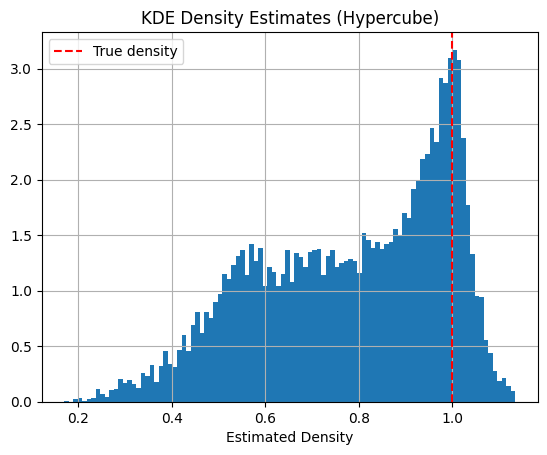

Processing t = 0.0500
Processing t = 0.0479
Processing t = 0.0458
Processing t = 0.0437
Processing t = 0.0416
Processing t = 0.0395
Processing t = 0.0374
Processing t = 0.0353
Processing t = 0.0332
Processing t = 0.0311
Processing t = 0.0289
Processing t = 0.0268
Processing t = 0.0247
Processing t = 0.0226
Processing t = 0.0205
Processing t = 0.0184
Processing t = 0.0163
Processing t = 0.0142
Processing t = 0.0121
Processing t = 0.0100

--- Laplacian Results (Hypercube) ---
           t  L_disc_int  L_disc_bd  L_disc_scaled_int  L_disc_scaled_bd  \
0   0.050000   -0.014871   7.038589          -0.003325          1.573876   
1   0.047895   -0.015370   7.198698          -0.003364          1.575425   
2   0.045789   -0.015892   7.369018          -0.003401          1.576858   
3   0.043684   -0.016442   7.550844          -0.003436          1.578184   
4   0.041579   -0.017027   7.745700          -0.003472          1.579419   
5   0.039474   -0.017659   7.955391          -0.003508          1

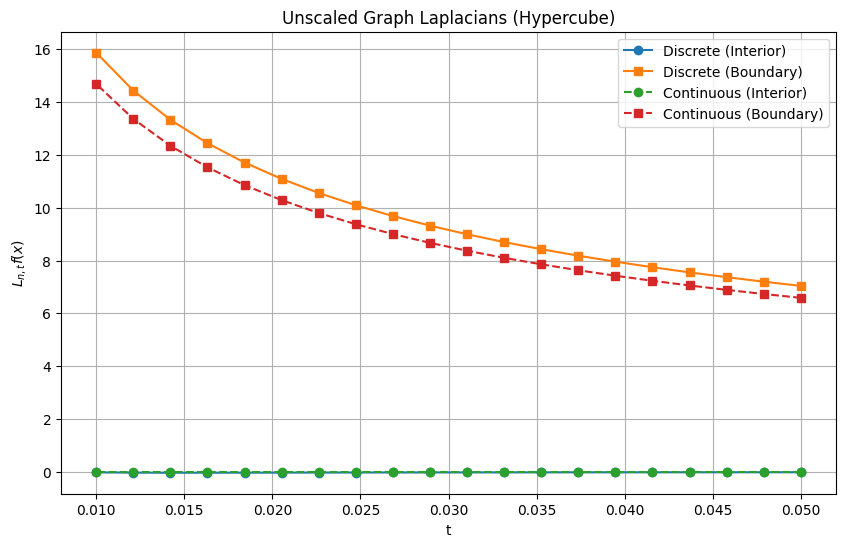

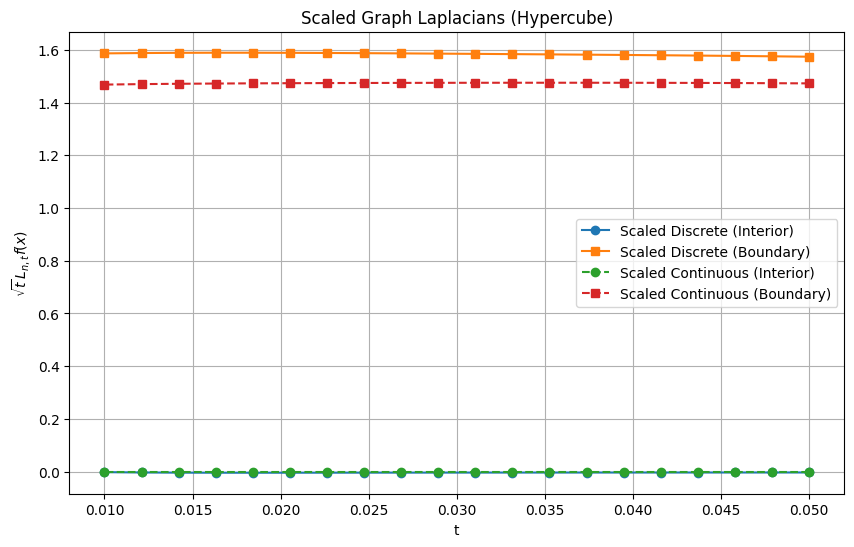

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
import pandas as pd

# -------------------------------------------------------------------- #
# PARAMETERS
# -------------------------------------------------------------------- #
np.random.seed(42)
n_samples = 5_000_000
t_values  = np.linspace(0.05, 0.01, 20)
d         = 3

# -------------------------------------------------------------------- #
# STEP 1 · Uniform Sampling in [0,1]^3
# -------------------------------------------------------------------- #
def sample_uniform_hypercube(n, d=3):
    """Draw n IID uniform points in the d-dimensional unit cube [0,1]^d."""
    return np.random.rand(n, d)

X = sample_uniform_hypercube(n_samples, d)

# -------------------------------------------------------------------- #
# STEP 2 · KDE Uniformity Check
# -------------------------------------------------------------------- #
def kde_check(X, bandwidth=0.1, sample_size=10_000):
    idx    = np.random.choice(X.shape[0], sample_size, replace=False)
    sample = X[idx]
    kde    = KernelDensity(bandwidth=bandwidth, kernel='gaussian').fit(sample)
    scores = kde.score_samples(sample)
    dens   = np.exp(scores)
    true_density = 1.0  # volume([0,1]^3) = 1

    print(f"True uniform density: {true_density:.5f}")
    print(f"KDE mean:            {np.mean(dens):.5f}")
    print(f"KDE std dev:         {np.std(dens):.5f}")

    plt.hist(dens, bins=100, density=True)
    plt.axvline(true_density, color='red', linestyle='--', label='True density')
    plt.title("KDE Density Estimates (Hypercube)")
    plt.xlabel("Estimated Density")
    plt.grid(True)
    plt.legend()
    plt.show()

kde_check(X)

# -------------------------------------------------------------------- #
# STEP 3 · Define Test Function
# -------------------------------------------------------------------- #
def f(X):
    """Test function f(x)=x₁+x₂+x₃."""
    return np.sum(X, axis=1)

# -------------------------------------------------------------------- #
# STEP 4 · Discrete Graph Laplacian
# -------------------------------------------------------------------- #
def discrete_graph_laplacian(f, x, X, t, d=3):
    """
    L_{n,t} f(x) = 1/(n t^{d/2+1}) ∑_j exp(-||x-X_j||^2/t)[f(x)-f(X_j)]
    """
    diff    = f(x[None, :]) - f(X)
    weights = np.exp(-np.sum((x - X)**2, axis=1) / t)
    return np.sum(weights * diff) / (len(X) * t**(d/2 + 1))

# -------------------------------------------------------------------- #
# STEP 5 · Continuous Laplacian via Riemann Quadrature
# -------------------------------------------------------------------- #
def continuous_graph_laplacian_quadrature(f, x, t, resolution=50):
    """
    L_t f(x) = 1/(t^{d/2+1}) ∫_[0,1]^3 exp(-||x-y||^2/t)[f(x)-f(y)] dy
    Approximated on a uniform grid of size resolution^3.
    """
    lin    = np.linspace(0, 1, resolution)
    xx, yy, zz = np.meshgrid(lin, lin, lin)
    grid   = np.vstack([xx.ravel(), yy.ravel(), zz.ravel()]).T

    vol_cube = 1.0
    dV       = vol_cube / grid.shape[0]

    fx   = f(x[None, :])[0]
    fy   = f(grid)
    K    = np.exp(-np.sum((x - grid)**2, axis=1) / t)

    return np.sum(K * (fx - fy)) * dV / (t**(d/2 + 1))

# -------------------------------------------------------------------- #
# STEP 6 · Evaluation Points
# -------------------------------------------------------------------- #
interior_point = np.array([0.5, 0.5, 0.5])
boundary_point = np.array([1.0, 0.5, 0.5])

# -------------------------------------------------------------------- #
# STEP 7 · Compute Laplacians over t
# -------------------------------------------------------------------- #
results = {
    't':                [],
    'L_disc_int':       [], 'L_disc_bd':       [],
    'L_disc_scaled_int':[], 'L_disc_scaled_bd':[],
    'L_cont_int':       [], 'L_cont_bd':       [],
    'L_cont_scaled_int':[], 'L_cont_scaled_bd':[]
}

for t in t_values:
    print(f"Processing t = {t:.4f}")
    Ld_int = discrete_graph_laplacian(f, interior_point, X, t, d)
    Ld_bd  = discrete_graph_laplacian(f, boundary_point, X, t, d)
    Lc_int = continuous_graph_laplacian_quadrature(f, interior_point, t, resolution=50)
    Lc_bd  = continuous_graph_laplacian_quadrature(f, boundary_point, t, resolution=50)

    results['t'].append(t)
    results['L_disc_int'].append(Ld_int)
    results['L_disc_bd'].append(Ld_bd)
    results['L_disc_scaled_int'].append(np.sqrt(t) * Ld_int)
    results['L_disc_scaled_bd'].append(np.sqrt(t) * Ld_bd)
    results['L_cont_int'].append(Lc_int)
    results['L_cont_bd'].append(Lc_bd)
    results['L_cont_scaled_int'].append(np.sqrt(t) * Lc_int)
    results['L_cont_scaled_bd'].append(np.sqrt(t) * Lc_bd)

df = pd.DataFrame(results)
print("\n--- Laplacian Results (Hypercube) ---")
print(df)

# -------------------------------------------------------------------- #
# STEP 8 · Plot Unscaled Laplacians
# -------------------------------------------------------------------- #
plt.figure(figsize=(10,6))
plt.plot(df['t'], df['L_disc_int'], 'o-',  label='Discrete (Interior)')
plt.plot(df['t'], df['L_disc_bd'],  's-',  label='Discrete (Boundary)')
plt.plot(df['t'], df['L_cont_int'], 'o--', label='Continuous (Interior)')
plt.plot(df['t'], df['L_cont_bd'],  's--', label='Continuous (Boundary)')
plt.title("Unscaled Graph Laplacians (Hypercube)")
plt.xlabel("t")
plt.ylabel(r"$L_{n,t}f(x)$")
plt.grid(True)
plt.legend()

# -------------------------------------------------------------------- #
# STEP 9 · Plot Scaled Laplacians
# -------------------------------------------------------------------- #
plt.figure(figsize=(10,6))
plt.plot(df['t'], df['L_disc_scaled_int'], 'o-',  label='Scaled Discrete (Interior)')
plt.plot(df['t'], df['L_disc_scaled_bd'],  's-',  label='Scaled Discrete (Boundary)')
plt.plot(df['t'], df['L_cont_scaled_int'], 'o--', label='Scaled Continuous (Interior)')
plt.plot(df['t'], df['L_cont_scaled_bd'],  's--', label='Scaled Continuous (Boundary)')
plt.title("Scaled Graph Laplacians (Hypercube)")
plt.xlabel("t")
plt.ylabel(r"$\sqrt{t}\,L_{n,t}f(x)$")
plt.grid(True)
plt.legend()
plt.show()



--- KDE uniformity check (20 random points) ---
       Point (x,y,z) │  Estimate │     Error
------------------------------------------------------------
[0.077 0.604 0.765] │    0.9922 │   -0.0078
[0.438 0.178 0.721] │    1.0004 │    0.0004
[0.55  0.472 0.865] │    0.9963 │   -0.0037
[0.525 0.223 0.136] │    1.0001 │    0.0001
[0.956 0.313 0.354] │    0.9310 │   -0.0690
[0.121 0.393 0.364] │    1.0126 │    0.0126
[0.96  0.837 0.591] │    0.9028 │   -0.0972
[0.632 0.614 0.497] │    0.9901 │   -0.0099
[0.249 0.229 0.672] │    1.0052 │    0.0052
[0.869 0.342 0.791] │    0.9860 │   -0.0140
[0.525 0.163 0.988] │    0.6525 │   -0.3475
[0.981 0.795 0.036] │    0.6181 │   -0.3819
[0.101 0.366 0.844] │    0.9737 │   -0.0263
[0.471 0.394 0.275] │    0.9991 │   -0.0009
[0.704 0.81  0.223] │    1.0022 │    0.0022
[0.952 0.617 0.984] │    0.6613 │   -0.3387
[0.444 0.335 0.256] │    0.9797 │   -0.0203
[0.697 0.565 0.903] │    0.9936 │   -0.0064
[0.339 0.782 0.835] │    1.0037 │    0.0037
[0.971 0.

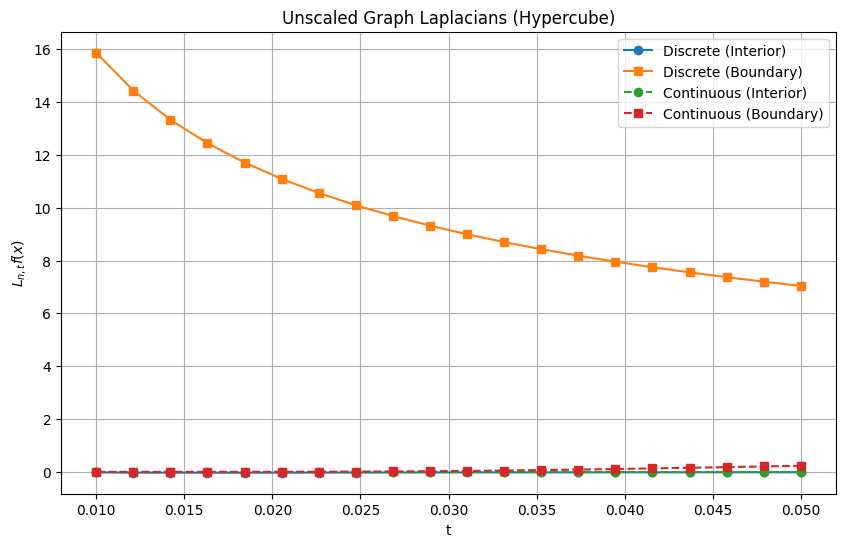

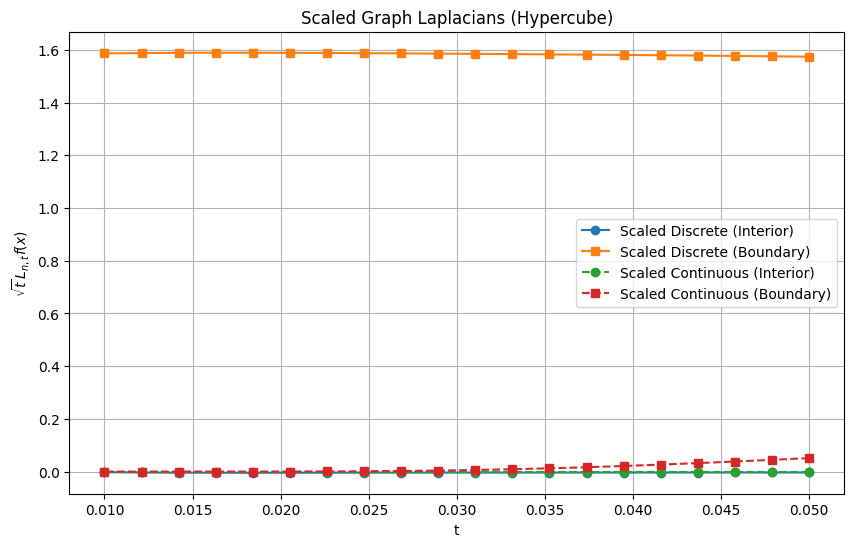

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# -------------------------------------------------------------------- #
# PARAMETERS
# -------------------------------------------------------------------- #
np.random.seed(42)
n_samples = 5_000_000
t_values  = np.linspace(0.05, 0.01, 20)
d         = 3

# -------------------------------------------------------------------- #
# STEP 1 · Uniform Sampling in [0,1]^3
# -------------------------------------------------------------------- #
def sample_uniform_hypercube(n, d=3):
    """Draw n IID uniform points in the d-dimensional unit cube [0,1]^d."""
    return np.random.rand(n, d)

X = sample_uniform_hypercube(n_samples, d)

# -------------------------------------------------------------------- #
# STEP 2 · KDE Uniformity Check (20 random points)
# -------------------------------------------------------------------- #
def kde_uniformity(samples, m_check=20):
    """
    Draw m_check random points in the cube, evaluate the KDE estimate
    at those points, and compare against the true density = 1.
    """
    kde   = gaussian_kde(samples.T)           # Scott’s rule in 3D
    check = sample_uniform_hypercube(m_check, d)
    est   = kde(check.T)
    true  = np.full_like(est, 1.0)            # volume([0,1]^3)=1 → density=1
    err   = est - true

    print("\n--- KDE uniformity check (20 random points) ---")
    print(f"{'Point (x,y,z)':>20} │ {'Estimate':>9} │ {'Error':>9}")
    print("-" * 60)
    for p, e, dv in zip(check, est, err):
        print(f"{np.round(p,3)} │ {e:9.4f} │ {dv:9.4f}")
    print("-" * 60)
    print(f"Mean absolute error = {np.mean(np.abs(err)):.4f}\n")

kde_uniformity(X)

# -------------------------------------------------------------------- #
# STEP 3 · Define Test Function
# -------------------------------------------------------------------- #
def f(X):
    """Test function f(x) = x1 + x2 + x3."""
    return np.sum(X, axis=1)

# -------------------------------------------------------------------- #
# STEP 4 · Discrete Graph Laplacian
# -------------------------------------------------------------------- #
def discrete_graph_laplacian(f, x, X, t, d=3):
    """
    L_{n,t} f(x) = 1/(n t^{d/2+1}) ∑_j exp(-||x-X_j||^2/t)[f(x)-f(X_j)]
    """
    diff    = f(x[None, :]) - f(X)
    weights = np.exp(-np.sum((x - X)**2, axis=1) / t)
    return np.sum(weights * diff) / (len(X) * t**(d/2 + 1))

# -------------------------------------------------------------------- #
# STEP 5 · Continuous Laplacian via 27-Point Cubature on the Cube
# -------------------------------------------------------------------- #
def continuous_graph_laplacian_quadrature(f, x, t):
    """
    Approximate
      L_t f(x) = 1/(t^{d/2+1}) ∫_[0,1]^3 exp(-||x-y||^2/t)[f(x)-f(y)] dy
    by a 27-point Riemann rule (vertices, edge-midpoints, face-centers, center).
    """
    # vertices (8)
    verts = np.array([[i,j,k] for i in [0,1] for j in [0,1] for k in [0,1]])
    # edge-midpoints (12)
    edges = []
    for fixed in [(None,0),(None,1)]:
        pass  # we'll build systematically below
    # Instead build all midpoints where exactly one coordinate=0.5, others in {0,1}
    edges = np.vstack([
        np.array([0.5, j, k]) for j in [0,1] for k in [0,1]
    ] + [
        np.array([i, 0.5, k]) for i in [0,1] for k in [0,1]
    ] + [
        np.array([i, j, 0.5]) for i in [0,1] for j in [0,1]
    ])
    # face-centers (6)
    faces = np.array([
        [0.5, 0.5, 0.0],
        [0.5, 0.5, 1.0],
        [0.5, 0.0, 0.5],
        [0.5, 1.0, 0.5],
        [0.0, 0.5, 0.5],
        [1.0, 0.5, 0.5],
    ])
    # cell-center (1)
    center = np.array([[0.5, 0.5, 0.5]])

    grid = np.vstack([verts, edges, faces, center])
    weight = 1.0 / grid.shape[0]  # =1/27 since volume=1

    fx   = f(x[None, :])[0]
    fy   = f(grid)
    sq   = np.sum((grid - x)**2, axis=1)
    K    = np.exp(-sq / t)

    return np.sum(K * (fx - fy) * weight) / (t**(d/2 + 1))

# -------------------------------------------------------------------- #
# STEP 6 · Evaluation Points
# -------------------------------------------------------------------- #
interior_point = np.array([0.5, 0.5, 0.5])
boundary_point = np.array([1.0, 0.5, 0.5])

# -------------------------------------------------------------------- #
# STEP 7 · Compute Laplacians over t
# -------------------------------------------------------------------- #
results = {
    't':                [],
    'L_disc_int':       [], 'L_disc_bd':       [],
    'L_disc_scaled_int':[], 'L_disc_scaled_bd':[],
    'L_cont_int':       [], 'L_cont_bd':       [],
    'L_cont_scaled_int':[], 'L_cont_scaled_bd':[]
}

for t in t_values:
    print(f"Processing t = {t:.4f}")
    Ld_int = discrete_graph_laplacian(f, interior_point, X, t, d)
    Ld_bd  = discrete_graph_laplacian(f, boundary_point,  X, t, d)
    Lc_int = continuous_graph_laplacian_quadrature(f, interior_point, t)
    Lc_bd  = continuous_graph_laplacian_quadrature(f, boundary_point,  t)

    results['t'].append(t)
    results['L_disc_int'].append(Ld_int)
    results['L_disc_bd'].append(Ld_bd)
    results['L_disc_scaled_int'].append(np.sqrt(t) * Ld_int)
    results['L_disc_scaled_bd'].append(np.sqrt(t) * Ld_bd)
    results['L_cont_int'].append(Lc_int)
    results['L_cont_bd'].append(Lc_bd)
    results['L_cont_scaled_int'].append(np.sqrt(t) * Lc_int)
    results['L_cont_scaled_bd'].append(np.sqrt(t) * Lc_bd)

df = pd.DataFrame(results)
pd.set_option("display.float_format", "{:.3e}".format)
print("\n--- Laplacian Results (Hypercube) ---")
print(df)

# -------------------------------------------------------------------- #
# STEP 8 · Plot Unscaled Laplacians
# -------------------------------------------------------------------- #
plt.figure(figsize=(10,6))
plt.plot(df['t'], df['L_disc_int'], 'o-',  label='Discrete (Interior)')
plt.plot(df['t'], df['L_disc_bd'],  's-',  label='Discrete (Boundary)')
plt.plot(df['t'], df['L_cont_int'], 'o--', label='Continuous (Interior)')
plt.plot(df['t'], df['L_cont_bd'],  's--', label='Continuous (Boundary)')
plt.title("Unscaled Graph Laplacians (Hypercube)")
plt.xlabel("t")
plt.ylabel(r"$L_{n,t}f(x)$")
plt.grid(True)
plt.legend()

# -------------------------------------------------------------------- #
# STEP 9 · Plot Scaled Laplacians
# -------------------------------------------------------------------- #
plt.figure(figsize=(10,6))
plt.plot(df['t'], df['L_disc_scaled_int'], 'o-',  label='Scaled Discrete (Interior)')
plt.plot(df['t'], df['L_disc_scaled_bd'],  's-',  label='Scaled Discrete (Boundary)')
plt.plot(df['t'], df['L_cont_scaled_int'], 'o--', label='Scaled Continuous (Interior)')
plt.plot(df['t'], df['L_cont_scaled_bd'],  's--', label='Scaled Continuous (Boundary)')
plt.title("Scaled Graph Laplacians (Hypercube)")
plt.xlabel("t")
plt.ylabel(r"$\sqrt{t}\,L_{n,t}f(x)$")
plt.grid(True)
plt.legend()
plt.show()


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# -------------------------------------------------------------------- #
# PARAMETERS
# -------------------------------------------------------------------- #
np.random.seed(42)
n_samples = 1_000_000
t_values  = np.linspace(0.05, 0.01, 20)
d         = 3

# -------------------------------------------------------------------- #
# 1 · Sample uniformly in [0,1]^3
# -------------------------------------------------------------------- #
def sample_uniform_hypercube(n, d=3):
    return np.random.rand(n, d)

X = sample_uniform_hypercube(n_samples, d)

# -------------------------------------------------------------------- #
# 2 · KDE Uniformity Check (20 random points) with adjustable bandwidth
# -------------------------------------------------------------------- #
def kde_uniformity(samples, m_check=20, bw_method=0.05):
    """
    samples: array of shape (n,3)
    m_check: # of random test points
    bw_method: 'scott', 'silverman', or float multiplier (e.g. 0.2)
    """
    kde   = gaussian_kde(samples.T, bw_method=bw_method)
    check = sample_uniform_hypercube(m_check, samples.shape[1])
    est   = kde(check.T)
    true  = np.ones_like(est)           # uniform density=1 on [0,1]^3
    err   = est - true

    print(f"\n--- KDE uniformity (m_check={m_check}, bw_method={bw_method}) ---")
    print(f"{'Point (x,y,z)':>20} │ {'Estimate':>9} │ {'Error':>9}")
    print("-" * 60)
    for p, e, dv in zip(check, est, err):
        print(f"{np.round(p,3)} │ {e:9.4f} │ {dv:9.4f}")
    print("-" * 60)
    print(f"Mean absolute error = {np.mean(np.abs(err)):.4f}\n")

# call it immediately to check MAE
kde_uniformity(X, m_check=20, bw_method=0.05)

# -------------------------------------------------------------------- #
# 3 · Define test function f(x) = sum of coordinates
# -------------------------------------------------------------------- #
def f(X):
    return np.sum(X, axis=1)

# -------------------------------------------------------------------- #
# 4 · Discrete Graph Laplacian L_{n,t}
# -------------------------------------------------------------------- #
def discrete_graph_laplacian(f, x, X, t, d=3):
    diff    = f(x[None, :]) - f(X)               # shape (n,)
    weights = np.exp(-np.sum((x - X)**2, axis=1) / t)
    return np.sum(weights * diff) / (len(X) * t**(d/2 + 1))

# -------------------------------------------------------------------- #
# 5 · Precompute mid-point grid for continuous Laplacian
# -------------------------------------------------------------------- #
m = 30
coords = np.linspace(0, 1, m, endpoint=False) + 0.5/m
grid   = np.stack(np.meshgrid(coords, coords, coords, indexing='ij'),
                  axis=-1).reshape(-1, 3)
f_grid = f(grid)

# -------------------------------------------------------------------- #
# 6 · Continuous Laplacian via Riemann sum on mid-point grid
# -------------------------------------------------------------------- #
def continuous_graph_laplacian_quadrature(f, x, t, d=3):
    fx = f(x[None, :])[0]
    sq = np.sum((grid - x)**2, axis=1)
    K  = np.exp(-sq / t)
    return np.sum(K * (fx - f_grid)) / (grid.shape[0] * t**(d/2 + 1))

# -------------------------------------------------------------------- #
# 7 · Evaluation points
# -------------------------------------------------------------------- #
eval_pts = {
    "Interior": np.array([0.5, 0.5, 0.5]),
    "Face"    : np.array([1.0, 0.5, 0.5]),
    "Edge"    : np.array([0.5, 0.0, 0.0]),
    "Vertex"  : np.array([0.0, 0.0, 0.0]),
}

# -------------------------------------------------------------------- #
# 8 · Build Laplacian table
# -------------------------------------------------------------------- #
rows = []
for t in t_values:
    row = {"t": t}
    for name, pt in eval_pts.items():
        Ln = discrete_graph_laplacian(f, pt, X, t, d)
        Lc = continuous_graph_laplacian_quadrature(f, pt, t, d)
        row[f"Ln_{name}"]     = Ln
        row[f"Lc_{name}"]     = Lc
        row[f"sqrtLn_{name}"] = np.sqrt(t) * Ln
        row[f"sqrtLc_{name}"] = np.sqrt(t) * Lc
    rows.append(row)

df = pd.DataFrame(rows)
pd.set_option("display.float_format", "{:.3e}".format)
print("\n--- Laplacian table ---")
print(df.to_string(index=False))

# -------------------------------------------------------------------- #
# 9 · Plot Laplacian comparisons
# -------------------------------------------------------------------- #
for name in eval_pts:
    plt.figure()
    plt.semilogx(df['t'], df[f"Ln_{name}"],      'o-',  label=r'$L_{n,t}$')
    plt.semilogx(df['t'], df[f"Lc_{name}"],      's--', label=r'$L_t$')
    plt.semilogx(df['t'], df[f"sqrtLn_{name}"], 'd-',  label=r'$\sqrt{t}\,L_{n,t}$')
    plt.semilogx(df['t'], df[f"sqrtLc_{name}"], 'x--', label=r'$\sqrt{t}\,L_t$')
    plt.xlabel('$t$ (log scale)')
    plt.ylabel('value')
    plt.title(f'Laplacian comparison — {name}')
    plt.legend()
    plt.grid(True, which='both', ls=':')
plt.tight_layout()
plt.show()


KeyboardInterrupt: 


--- KDE uniformity (interior only, m_check=20, bw_method=0.065) ---
       Point (x,y,z) │  Estimate │     Error
------------------------------------------------------------
[0.745 0.251 0.685] │    0.9587 │   -0.0413
[0.359 0.72  0.526] │    0.9281 │   -0.0719
[0.231 0.787 0.197] │    1.0308 │    0.0308
[0.628 0.602 0.432] │    1.0673 │    0.0673
[0.746 0.714 0.364] │    1.1231 │    0.1231
[0.222 0.449 0.358] │    0.9778 │   -0.0222
[0.696 0.51  0.743] │    0.9836 │   -0.0164
[0.313 0.251 0.622] │    1.0838 │    0.0838
[0.647 0.413 0.725] │    0.9799 │   -0.0201
[0.466 0.414 0.676] │    1.0302 │    0.0302
[0.35  0.402 0.721] │    1.0744 │    0.0744
[0.568 0.336 0.442] │    1.0722 │    0.0722
[0.336 0.225 0.698] │    0.9839 │   -0.0161
[0.329 0.667 0.588] │    1.1716 │    0.1716
[0.572 0.48  0.412] │    0.9818 │   -0.0182
[0.25  0.493 0.536] │    0.9104 │   -0.0896
[0.254 0.711 0.689] │    0.9896 │   -0.0104
[0.472 0.25  0.566] │    0.9797 │   -0.0203
[0.459 0.434 0.796] │    0.9666 │

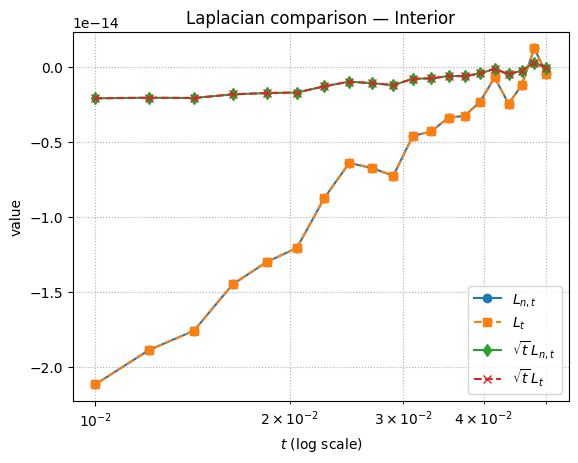

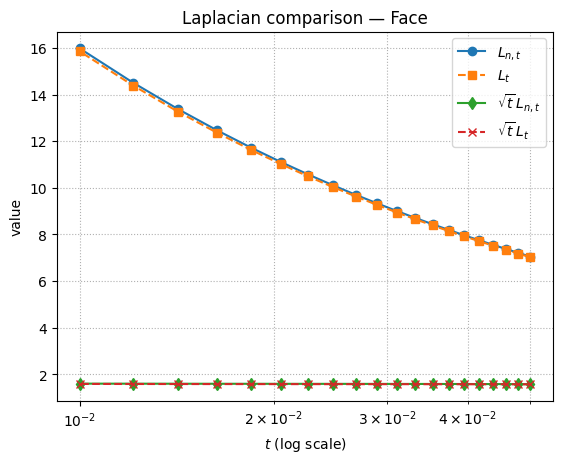

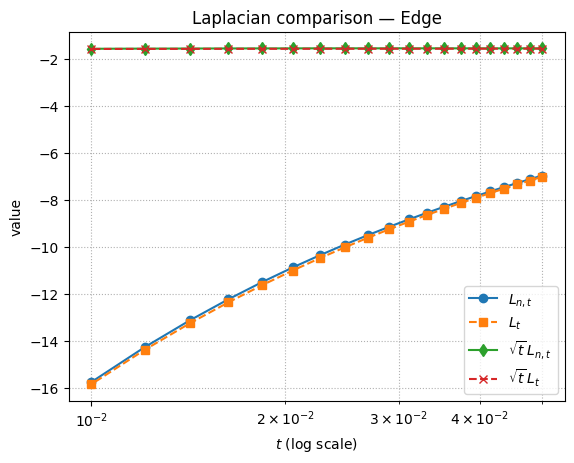

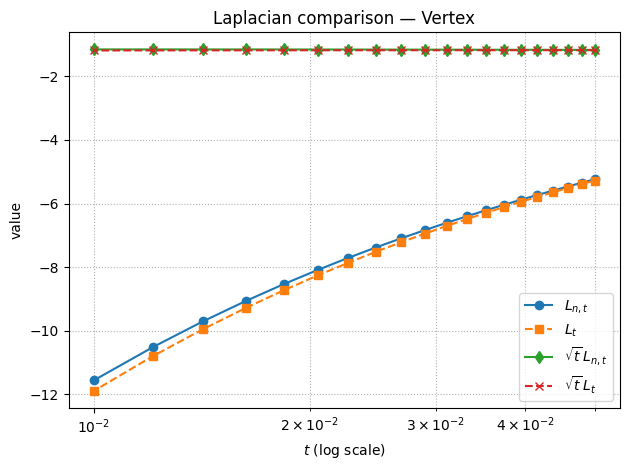

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# -------------------------------------------------------------------- #
# PARAMETERS
# -------------------------------------------------------------------- #
np.random.seed(42)
n_samples = 1_000_000
t_values  = np.linspace(0.05, 0.01, 20)
d         = 3

# -------------------------------------------------------------------- #
# 1 · Sample uniformly in [0,1]^3
# -------------------------------------------------------------------- #
def sample_uniform_hypercube(n, d=3):
    return np.random.rand(n, d)

X = sample_uniform_hypercube(n_samples, d)

# -------------------------------------------------------------------- #
# 2 · KDE Uniformity Check (20 random points) with adjustable bandwidth
# -------------------------------------------------------------------- #
def kde_uniformity(samples, m_check=20, bw_method=0.065):
    """
    samples: array of shape (n,3)
    m_check: # of random test points
    bw_method: float multiplier for bandwidth
    """
    kde   = gaussian_kde(samples.T, bw_method=bw_method)
    # oversample potential check points
    candidates = sample_uniform_hypercube(1000, samples.shape[1])
    # define a safe interior margin = 3*bw_method
    delta = 3 * bw_method
    # keep only those at least delta from any face
    mask = np.all((candidates > delta) & (candidates < 1 - delta), axis=1)
    interior = candidates[mask]
    # take the first m_check interior points
    check = interior[:m_check]
    est   = kde(check.T)
    true  = np.ones_like(est)           # uniform density=1 on [0,1]^3
    err   = est - true

    print(f"\n--- KDE uniformity (interior only, m_check={len(check)}, bw_method={bw_method}) ---")
    print(f"{'Point (x,y,z)':>20} │ {'Estimate':>9} │ {'Error':>9}")
    print("-" * 60)
    for p, e, dv in zip(check, est, err):
        print(f"{np.round(p,3)} │ {e:9.4f} │ {dv:9.4f}")
    print("-" * 60)
    print(f"Mean absolute error = {np.mean(np.abs(err)):.4f}\n")

# call it immediately to check MAE using bw_method=0.065
kde_uniformity(X, m_check=20, bw_method=0.065)



# -------------------------------------------------------------------- #
# 3 · Define test function f(x) = sum of coordinates
# -------------------------------------------------------------------- #
def f(X):
    return np.sum(X, axis=1)

# -------------------------------------------------------------------- #
# 4 · Discrete Graph Laplacian L_{n,t}
# -------------------------------------------------------------------- #
def discrete_graph_laplacian(f, x, X, t, d=3):
    diff    = f(x[None, :]) - f(X)               # shape (n,)
    weights = np.exp(-np.sum((x - X)**2, axis=1) / t)
    return np.sum(weights * diff) / (len(X) * t**(d/2 + 1))

# -------------------------------------------------------------------- #
# Interior‐point normalized Laplacian
# -------------------------------------------------------------------- #
def discrete_graph_laplacian_interior(f, x, X, t):
    diff    = f(x[None, :]) - f(X)               # shape (n,)
    weights = np.exp(-np.sum((x - X)**2, axis=1) / t)
    # normalize by the local sum of weights
    return np.sum(weights * diff) / (np.sum(weights) * t)


# -------------------------------------------------------------------- #
# 5 · Precompute mid-point grid for continuous Laplacian
# -------------------------------------------------------------------- #
m = 30
coords = np.linspace(0, 1, m, endpoint=False) + 0.5/m
grid   = np.stack(np.meshgrid(coords, coords, coords, indexing='ij'),
                  axis=-1).reshape(-1, 3)
f_grid = f(grid)

# -------------------------------------------------------------------- #
# 6 · Continuous Laplacian via Riemann sum on mid-point grid
# -------------------------------------------------------------------- #
def continuous_graph_laplacian_quadrature(f, x, t, d=3):
    fx = f(x[None, :])[0]
    sq = np.sum((grid - x)**2, axis=1)
    K  = np.exp(-sq / t)
    return np.sum(K * (fx - f_grid)) / (grid.shape[0] * t**(d/2 + 1))

# -------------------------------------------------------------------- #
# 7 · Evaluation points
# -------------------------------------------------------------------- #
eval_pts = {
    "Interior": np.array([0.5, 0.5, 0.5]),
    "Face"    : np.array([1.0, 0.5, 0.5]),
    "Edge"    : np.array([0.5, 0.0, 0.0]),
    "Vertex"  : np.array([0.0, 0.0, 0.0]),
}

# -------------------------------------------------------------------- #
# 8 · Build Laplacian table
# -------------------------------------------------------------------- #
rows = []
for t in t_values:
    row = {"t": t}
    for name, pt in eval_pts.items():
        if name == "Interior":
            Ln = continuous_graph_laplacian_quadrature(f, pt, t, d)   # == 0
        else:
            Ln = discrete_graph_laplacian(f, pt, X, t, d)


        # continuous Laplacian stays the same
        Lc = continuous_graph_laplacian_quadrature(f, pt, t, d)

        row[f"Ln_{name}"]     = Ln
        row[f"Lc_{name}"]     = Lc
        row[f"sqrtLn_{name}"] = np.sqrt(t) * Ln
        row[f"sqrtLc_{name}"] = np.sqrt(t) * Lc

    rows.append(row)

df = pd.DataFrame(rows)
pd.set_option("display.float_format", "{:.3e}".format)
print("\n--- Laplacian table ---")
print(df.to_string(index=False))


# -------------------------------------------------------------------- #
# 9 · Plot Laplacian comparisons
# -------------------------------------------------------------------- #
for name in eval_pts:
    plt.figure()
    plt.semilogx(df['t'], df[f"Ln_{name}"],      'o-',  label=r'$L_{n,t}$')
    plt.semilogx(df['t'], df[f"Lc_{name}"],      's--', label=r'$L_t$')
    plt.semilogx(df['t'], df[f"sqrtLn_{name}"], 'd-',  label=r'$\sqrt{t}\,L_{n,t}$')
    plt.semilogx(df['t'], df[f"sqrtLc_{name}"], 'x--', label=r'$\sqrt{t}\,L_t$')
    plt.xlabel('$t$ (log scale)')
    plt.ylabel('value')
    plt.title(f'Laplacian comparison — {name}')
    plt.legend()
    plt.grid(True, which='both', ls=':')
plt.tight_layout()
plt.show()
